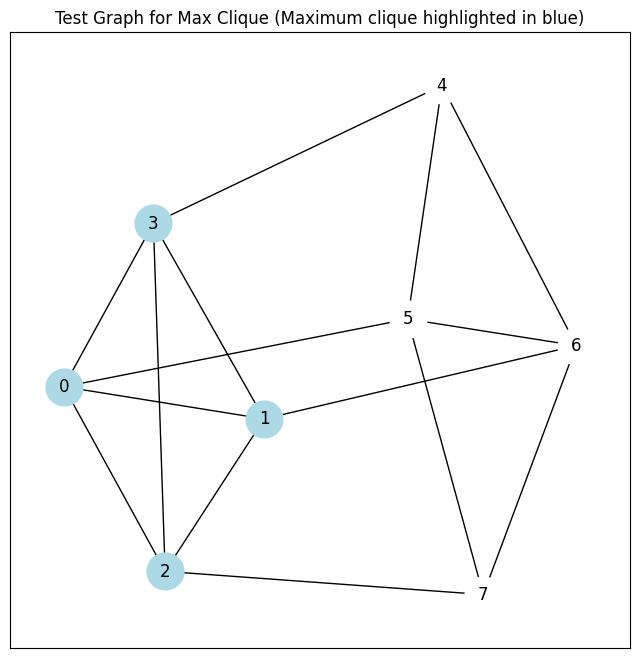

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a graph with known maximum clique
def generate_test_graph():
    G = nx.Graph()
    # Create a graph with a known maximum clique of size 4
    # First add the maximum clique (nodes 0,1,2,3 fully connected)
    for i in range(4):
        for j in range(i+1, 4):
            G.add_edge(i, j)
    # Add additional nodes and edges to make it more complex
    G.add_edges_from([
        (3,4), (4,5), (5,6), (6,7), # Path of additional nodes
        (0,5), (1,6), (2,7),        # Some cross edges
        (4,6), (5,7)                 # Additional edges to create smaller cliques
    ])
    return G
G = generate_test_graph()
# Visualization of the graph with maximum clique highlighted
def plot_graph(G):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8,8))
    # Draw the main graph
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    # Draw nodes with different colors for the maximum clique
    max_clique_nodes = [0,1,2,3]  # Known maximum clique
    other_nodes = list(set(G.nodes()) - set(max_clique_nodes))
    nx.draw_networkx_nodes(G, pos, nodelist=max_clique_nodes,
                          node_color='lightblue', node_size=700)
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes,
                          node_color='white', node_size=700)
    plt.title("Test Graph for Max Clique (Maximum clique highlighted in blue)")
    plt.show()
plot_graph(G)

In [2]:
from max_clique_qaoa.problem_setup.utils import get_QUBO_from_graph, get_hamiltonian_from_QUBO
qubo = get_QUBO_from_graph(G)
hamiltonian = get_hamiltonian_from_QUBO(qubo)